In [1]:
# Directory where the data is present
data_dir = '../input/optiver-realized-volatility-prediction/'

# calculating first Weighted Average Price
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Calculating second Weighted Average Price
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Calculating third Weighted Average Price
def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Calculating fourth Weighted Average Price
def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# where logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculating the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Counting unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [2]:
import pandas as pd

#function to read the train and the test files

def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

    return train,test

In [3]:
from joblib import Parallel,delayed
import numpy as np

def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dictionary for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [4]:
import os
import gc

# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train) 
test = get_time_stock(test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 33.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [5]:
!pip install catboost
!pip install ipywidgets

In [6]:
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

In [7]:
# The row id column dropped since it is not compatible

for col in train:
    if train[col].dtypes=='object':
        train = train.drop(col, axis=1)

for col in test:
    if test[col].dtypes=='object':
        test = test.drop(col, axis=1)



Training fold 1
[     1      2      3 ... 321695 321696 321697]
[     0      4      6 ... 321684 321690 321698]
Learning rate set to 0.49585
0:	learn: 0.0019655	test: 0.0019357	best: 0.0019357 (0)	total: 297ms	remaining: 29.4s
1:	learn: 0.0015455	test: 0.0015196	best: 0.0015196 (1)	total: 485ms	remaining: 23.8s
2:	learn: 0.0013760	test: 0.0013549	best: 0.0013549 (2)	total: 629ms	remaining: 20.4s
3:	learn: 0.0013066	test: 0.0012901	best: 0.0012901 (3)	total: 777ms	remaining: 18.7s
4:	learn: 0.0012770	test: 0.0012622	best: 0.0012622 (4)	total: 926ms	remaining: 17.6s
5:	learn: 0.0012595	test: 0.0012468	best: 0.0012468 (5)	total: 1.05s	remaining: 16.5s
6:	learn: 0.0012467	test: 0.0012341	best: 0.0012341 (6)	total: 1.18s	remaining: 15.7s
7:	learn: 0.0012379	test: 0.0012281	best: 0.0012281 (7)	total: 1.34s	remaining: 15.4s
8:	learn: 0.0012305	test: 0.0012203	best: 0.0012203 (8)	total: 1.51s	remaining: 15.3s
9:	learn: 0.0012247	test: 0.0012153	best: 0.0012153 (9)	total: 1.68s	remaining: 15.1s

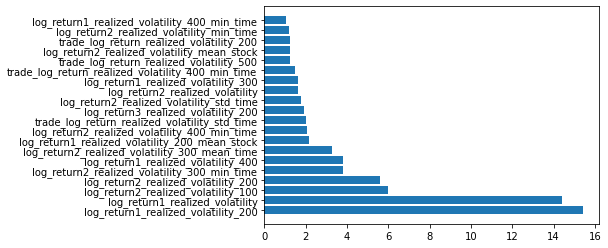

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
import catboost
from catboost import EFstrType
import sys
import matplotlib.pyplot as plt

#Function to calculate the RMSPE

def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return loss

#Function to train and evaluate Cat Boost Algorithm

def train_and_evaluate_cb(train, test):
    
    
    features = [col for col in train.columns if col not in {"row_id"}]
    train_features = [col for col in train.columns if col not in {"target","row_id"}]
    test_features = [col for col in train.columns if col not in {"row_id"}]
    
    X = train[train_features]
    y = train['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=True)
        
    # Create out of folds array
    oof_predictions = np.zeros(X_train.shape[0])
    oof_actual = np.zeros(X_train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(X_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, shuffle = True) #random_state = 2021, 
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(X_train)):
        print(f'Training fold {fold + 1}')
        print(trn_ind)
        print(val_ind)
        x_t, x_val = X_train.iloc[trn_ind], X_train.iloc[val_ind]
        y_t, y_val = y_train.iloc[trn_ind], y_train.iloc[val_ind]
        
        #x_train = x_train[train_features]
        #x_val = x_val[train_features]
        
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        
        #train_dataset = Dataset(x_train[features], y_train, weight = train_weights)
        #val_dataset = Dataset(x_val[features], y_val, weight = val_weights)
        
        #Setting up the model
        catboost_model = CatBoostRegressor(n_estimators=100,
                                   loss_function = 'RMSE',
                                   eval_metric = 'RMSE',
                                   cat_features = None)
        #Fitting the Catboost Model
        catboost_model.fit(x_t, y_t, 
                   eval_set = (x_val, y_val),
                   use_best_model = True, 
                   plot = False)
        
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = catboost_model.predict(x_val)
        oof_actual[val_ind] = y_val
        
        # Predict the test set
        test_predictions += catboost_model.predict(X_test) / 5
        
        
    #Calculating the RMSPE score
    rmspe_score = rmspe(oof_actual, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    
    r2 = r2_score(oof_actual, oof_predictions)
    print(f'Our out of folds R2 score is {r2}')
        
    #f1 = f1_score(oof_actual, oof_predictions)
    #print(f'Our out of folds R2 score is {f1}')
    
    catboost_model = CatBoostRegressor(n_estimators=100,
                                   loss_function = 'RMSE',
                                   eval_metric = 'RMSE',
                                   cat_features = None)
    
    #Fitting the Catboost Model
    catboost_model.fit(X_train, y_train, eval_set = (X_test, y_test),
                   use_best_model = True, 
                   plot = False)
    #Getting the feature importance for CatBoost
    imp = catboost_model.get_feature_importance(type=catboost.EFstrType.FeatureImportance, prettified=True, thread_count=-1, verbose=False)
    
    print(imp)
    feature = imp["Feature Id"][0:20]
    importances = imp["Importances"][0:20]
    
    plt.barh(feature, importances)#, color ='maroon',width = 0.1)
    
    # Return test predictions
    return test_predictions, oof_predictions, oof_actual


# Traing and evaluate
#categorical_feat_idx_train = np.where(train.dtypes != np.float)[0]
#categorical_feat_idx_test = np.where(test.dtypes != np.float)[0]

predictions_cb, _, _= train_and_evaluate_cb(train, test)

#Get the predictions of the test data
#test['target'] = predictions_cb
test_out = pd.DataFrame(predictions_cb, columns=['target'])


#Save the predictinos of the test data into "submission_catboost.csv" file
test_out['target'].to_csv('submission_catboost.csv',index = False)

Training fold 1
[     0      1      2 ... 321696 321697 321698]
[     3      5      7 ... 321690 321691 321693]


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.9933e-07	training's RMSPE: 0.205927	valid_1's l2: 2.11265e-07	valid_1's RMSPE: 0.21392
[500]	training's l2: 1.78279e-07	training's RMSPE: 0.194749	valid_1's l2: 1.97527e-07	valid_1's RMSPE: 0.206848
[750]	training's l2: 1.66295e-07	training's RMSPE: 0.18809	valid_1's l2: 1.91288e-07	valid_1's RMSPE: 0.203555
[1000]	training's l2: 1.57166e-07	training's RMSPE: 0.182854	valid_1's l2: 1.86662e-07	valid_1's RMSPE: 0.201079
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 1.57166e-07	training's RMSPE: 0.182854	valid_1's l2: 1.86662e-07	valid_1's RMSPE: 0.201079
Training fold 2
[     0      1      2 ... 321694 321695 321698]
[     8     22     32 ... 321687 321696 321697]
Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.96871e-07	training's RMSPE: 0.205315	valid_1's l2: 2.34505e-07	valid_1's RMSPE: 0.222489
[500]	training's l2: 1.76764e-07	training's RMS

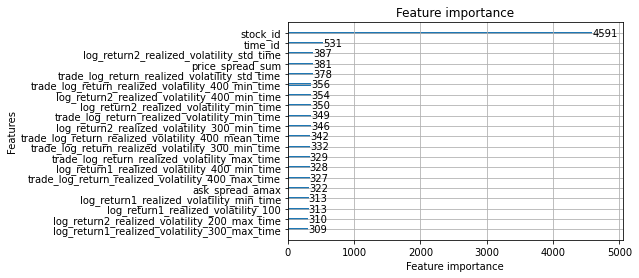

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"row_id"}]
    train_features = [col for col in train.columns if col not in {"target","row_id"}]
    test_features = [col for col in train.columns if col not in {"row_id"}]
    
    X = train[train_features]
    y = train['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=True)
    
    # Create out of folds array
    oof_predictions = np.zeros(X_train.shape[0])
    oof_actual = np.zeros(X_train.shape[0])
    
    # Create test array to store predictions
    test_predictions = np.zeros(X_test.shape[0])
    
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(X_train)):
        print(f'Training fold {fold + 1}')
        print(trn_ind)
        print(val_ind)
        x_t, x_val = X_train.iloc[trn_ind], X_train.iloc[val_ind]
        y_t, y_val = y_train.iloc[trn_ind], y_train.iloc[val_ind]
        
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_t)
        val_weights = 1 / np.square(y_val)
        
        train_dataset = lgb.Dataset(x_t[train_features], y_t, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[train_features], y_val, weight = val_weights)
        
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        oof_actual[val_ind] = y_val
        
        # Predict the test set
        test_predictions += model.predict(X_test) / 5
        
    rmspe_score = rmspe(oof_actual, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    
    r2 = r2_score(oof_actual, oof_predictions)
    print(f'Our out of folds R2 score is {r2}')
    
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions, oof_predictions, oof_actual

# Traing and evaluate
predictions_lgb, _, _= train_and_evaluate_lgb(train, test,params0)

#test['target'] = predictions_lgb
test_out = pd.DataFrame(predictions_lgb, columns=['target'])

#Save the predictinos of the test data into "submission_lightgbm.csv" file
test_out['target'].to_csv('submission_lightgbm.csv',index = False)

Training fold 1
[     1      2      3 ... 321693 321695 321697]
[     0     14     15 ... 321694 321696 321698]
Learning rate set to 0.49585
0:	learn: 0.0019495	test: 0.0019384	best: 0.0019384 (0)	total: 264ms	remaining: 26.2s
1:	learn: 0.0015338	test: 0.0015255	best: 0.0015255 (1)	total: 499ms	remaining: 24.5s
2:	learn: 0.0013633	test: 0.0013617	best: 0.0013617 (2)	total: 704ms	remaining: 22.8s
3:	learn: 0.0012975	test: 0.0012993	best: 0.0012993 (3)	total: 920ms	remaining: 22.1s
4:	learn: 0.0012678	test: 0.0012744	best: 0.0012744 (4)	total: 1.08s	remaining: 20.4s
5:	learn: 0.0012479	test: 0.0012568	best: 0.0012568 (5)	total: 1.23s	remaining: 19.2s
6:	learn: 0.0012365	test: 0.0012483	best: 0.0012483 (6)	total: 1.39s	remaining: 18.5s
7:	learn: 0.0012262	test: 0.0012387	best: 0.0012387 (7)	total: 1.54s	remaining: 17.8s
8:	learn: 0.0012185	test: 0.0012327	best: 0.0012327 (8)	total: 1.67s	remaining: 16.9s
9:	learn: 0.0012061	test: 0.0012212	best: 0.0012212 (9)	total: 1.84s	remaining: 16.5s

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.97604e-07	training's RMSPE: 0.205748	valid_1's l2: 2.1629e-07	valid_1's RMSPE: 0.214894
[500]	training's l2: 1.77222e-07	training's RMSPE: 0.194848	valid_1's l2: 2.02993e-07	valid_1's RMSPE: 0.208184
[750]	training's l2: 1.65455e-07	training's RMSPE: 0.188269	valid_1's l2: 1.96902e-07	valid_1's RMSPE: 0.205037
[1000]	training's l2: 1.56532e-07	training's RMSPE: 0.183122	valid_1's l2: 1.92703e-07	valid_1's RMSPE: 0.202839
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 1.56532e-07	training's RMSPE: 0.183122	valid_1's l2: 1.92703e-07	valid_1's RMSPE: 0.202839
Training fold 2
[     0      1      2 ... 321694 321695 321698]
[     8     22     32 ... 321687 321696 321697]
Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.98091e-07	training's RMSPE: 0.205869	valid_1's l2: 2.30143e-07	valid_1's RMSPE: 0.22224
[500]	training's l2: 1.77954e-07	training's RM

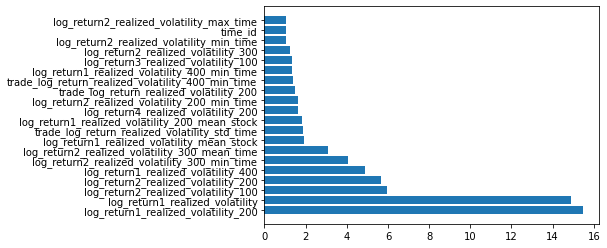

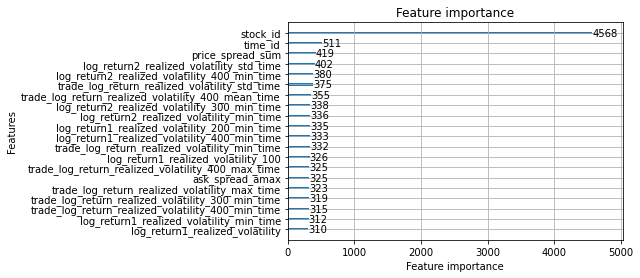

In [11]:
#Building the ensemble model
predictions_cb, oof_pred_cb, oof_actual_cb = train_and_evaluate_cb(train, test)
predictions_lgb, oof_pred_lgb, oof_actual_lgb = train_and_evaluate_lgb(train, test, params0)

# Carry out ensemble code here
cb_pred_wt = [x*2 for x in oof_pred_cb]
lgb_pred_wt = [x*1 for x in oof_pred_lgb]
wt_pred = []
for (x1,x2) in zip(cb_pred_wt, lgb_pred_wt):
    wt_pred.append(x1+x2)

pred_ensemble = [y/3 for y in wt_pred]

rmspe_score = rmspe(oof_actual_cb, pred_ensemble)
print(f'Our out of folds RMSPE for Ensemble model is {rmspe_score}')
    
r2 = r2_score(oof_actual_cb, pred_ensemble)
print(f'Our out of folds R2 score for Ensemble model is {r2}')